In [31]:
import drjit as dr
import mitsuba as mi
import numpy as np

mi.set_variant('cuda_ad_rgb')

In [32]:
scene = mi.load_file('../scenes/cbox-sch-modified/cbox-multiple-lights.xml')

In [33]:
image_ref = mi.render(scene, spp=1024)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [34]:
params = mi.traverse(scene)

In [35]:
reflectanceKeys = []
for key in params.keys():
    if 'radiance' in key:
        reflectanceKeys.append(key)

In [36]:
reflectanceKeys

['PLYMesh.emitter.radiance.value',
 'PLYMesh_1.emitter.radiance.value',
 'PLYMesh_2.emitter.radiance.value',
 'PLYMesh_3.emitter.radiance.value',
 'PLYMesh_4.emitter.radiance.value',
 'PLYMesh_5.emitter.radiance.value',
 'PLYMesh_6.emitter.radiance.value']

In [37]:
# Save the original value
param_refs = dict(zip(reflectanceKeys, [mi.Color3f(params[key]) for key in reflectanceKeys]))

# Initialize the random number generator
numOfChannels = 3
rng = mi.PCG32(size=numOfChannels * len(param_refs))
samples = rng.next_float64() * 500.0

# Set another color value and update the scene
for i, key in enumerate(reflectanceKeys):
    params[key] = mi.Color3f(
        samples[i*numOfChannels], samples[i*numOfChannels+1], samples[i*numOfChannels+2])

params.update();

In [38]:
for key in reflectanceKeys:
    print('key:', key)
    print('orig:', param_refs[key])
    print('modified:', params[key])

key: PLYMesh.emitter.radiance.value
orig: [[72.29999542236328, 72.29999542236328, 72.29999542236328]]
modified: [[54.189353942871094, 79.20679473876953, 486.7416687011719]]
key: PLYMesh_1.emitter.radiance.value
orig: [[100.0, 100.0, 100.0]]
modified: [[3.4222607612609863, 28.73792266845703, 287.5155334472656]]
key: PLYMesh_2.emitter.radiance.value
orig: [[300.0, 176.51596069335938, 83.19548034667969]]
modified: [[435.9079284667969, 367.6947937011719, 391.4736022949219]]
key: PLYMesh_3.emitter.radiance.value
orig: [[100.0, 100.0, 100.0]]
modified: [[248.9824981689453, 41.236080169677734, 23.194456100463867]]
key: PLYMesh_4.emitter.radiance.value
orig: [[300.0, 176.51596069335938, 83.19548034667969]]
modified: [[407.9986267089844, 431.2792053222656, 466.9787902832031]]
key: PLYMesh_5.emitter.radiance.value
orig: [[1.0, 0.8025850057601929, 0.3121449947357178]]
modified: [[282.15618896484375, 88.09204864501953, 355.6101989746094]]
key: PLYMesh_6.emitter.radiance.value
orig: [[100.0, 84.254

In [39]:
# reflactence optimizer
init_learning_rate = 100.0
midway_learning_rate = 10.0
late_learning_rate = 1.0
latelate_learning_rate = 0.1
reflectanceOpt = mi.ad.Adam(lr=init_learning_rate)
for key in reflectanceKeys:
    reflectanceOpt[key] = params[key]
params.update(reflectanceOpt);

In [40]:
img_init = mi.render(scene, spp=256) # seed = 0 missing
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [41]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In [42]:
iteration_count = 100
minError = 0.1

In [43]:
loss_hist = []
err_refs = dict(zip(reflectanceKeys, dr.full(mi.Float,  dr.inf, len(reflectanceKeys))))

In [44]:
for it in range(iteration_count):

    # check all optimization parameters and if defined threshold is achieved
    # stop optimization for that parameter
    # TODO currently dirty
    shouldStop = True
    for key in err_refs:
        if err_refs[key] < minError:
            if key in reflectanceOpt:
                reflectanceOpt.variables.pop(key)
                print('Resetted optimization:', key)
            shouldStop = shouldStop & True
        else:
            shouldStop = False

    # stop optimization if all optimization parameters achieved to reach some
    # defined threshold
    if shouldStop:
        break


    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=4)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)
    # loss = dr.sum(dr.sqr(image - image_ref)) / len(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    reflectanceOpt.step()

    # Post-process the optimized parameters to ensure legal radiance values.
    for key in reflectanceKeys:
        if key in reflectanceOpt:
            reflectanceOpt[key] = dr.clamp(reflectanceOpt[key], 0.0, 1000.0)

    # Update the scene state to the new optimized values
    params.update(reflectanceOpt)

    print(f"Iteration {it:02d}")
    for key in param_refs:
        tmp = params[key]
        err_ref = dr.sum(dr.sqr(param_refs[key] - tmp))
        err_refs[key] = err_ref[0]
        print(f"\tkey= {key} error= {err_ref[0]:6f}")

        # TODO dirty, decrease learning rate
        if err_refs[key] < 100 and reflectanceOpt.lr[key] > midway_learning_rate:
            print('Decreased learning rate for', key)
            reflectanceOpt.set_learning_rate({key: midway_learning_rate})
        # elif err_refs[key] < 10 and reflectanceOpt.lr[key] > late_learning_rate:
        #     print('Decreased learning rate for', key)
        #     reflectanceOpt.set_learning_rate({key: late_learning_rate})


    loss_hist.append(loss)
print('\nOptimization complete.')

Iteration 00
	key= PLYMesh.emitter.radiance.value error= 110800.718750
	key= PLYMesh_1.emitter.radiance.value error= 27967.521484
	key= PLYMesh_2.emitter.radiance.value error= 53049.363281
	key= PLYMesh_3.emitter.radiance.value error= 22497.480469
	key= PLYMesh_4.emitter.radiance.value error= 248190.078125
	key= PLYMesh_5.emitter.radiance.value error= 97995.304688
	key= PLYMesh_6.emitter.radiance.value error= 130485.609375
Iteration 01
	key= PLYMesh.emitter.radiance.value error= 46792.199219
	key= PLYMesh_1.emitter.radiance.value error= 20056.867188
	key= PLYMesh_2.emitter.radiance.value error= 15569.259766
	key= PLYMesh_3.emitter.radiance.value error= 22114.000000
	key= PLYMesh_4.emitter.radiance.value error= 184395.765625
	key= PLYMesh_5.emitter.radiance.value error= 31936.361328
	key= PLYMesh_6.emitter.radiance.value error= 43361.234375
Iteration 02
	key= PLYMesh.emitter.radiance.value error= 20072.093750
	key= PLYMesh_1.emitter.radiance.value error= 29923.751953
	key= PLYMesh_2.emi

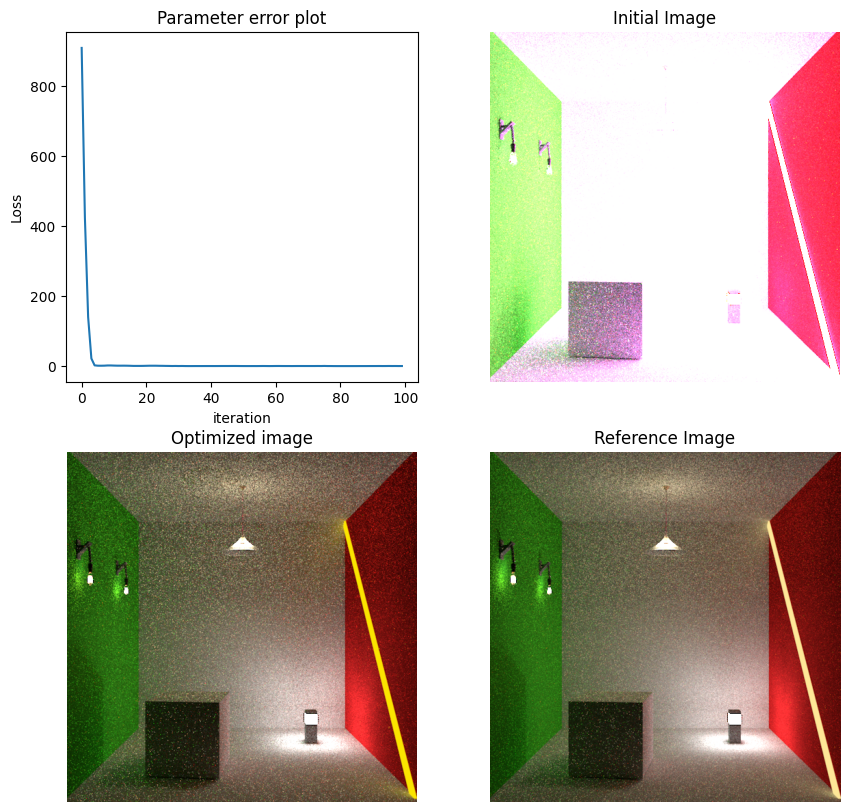

In [45]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=512)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

fig.savefig('optimization-test-figure.png')